# cDIA (difference image analysis with cropped exposures)

# Import

In [280]:
import cDIA as cdia
import importlib as imp
imp.reload(cdia)

<module 'cDIA' from '/pscratch/sd/s/shl159/projects/update_plots/dia_improvement/devel/cDIA.py'>

In [290]:
import matplotlib.pyplot as plt
import numpy as np
import os
import lsst
from lsst.daf.butler import Butler
from lsst.ip.diffim import GetTemplateConfig, GetTemplateTask
import lsst.afw.image as afwImage
from lsst.afw.table import BaseCatalog
import lsst.afw.display as afwDisplay


In [182]:
def htm_from_ra_dec_level(ra, dec, level):
    pixelization = lsst.sphgeom.HtmPixelization(level)
    htm_id = pixelization.index(
        lsst.sphgeom.UnitVector3d(
            lsst.sphgeom.LonLat.fromDegrees(ra, dec)
        )
    )
    return htm_id

def get_dataset_refs_from_htm_list(dataset_type, htm_ids, level, aggregate="intersection"):
    hi = htm_ids[0]

    # dataset_refs is an iterator, but each query is only a few hundred results,
    #   so convert to a list for future convenience
    htm_kwargs = {}
    htm_kwargs[f"htm{level}"] = hi
    dataset_refs = list(butler.registry.queryDatasets(dataset_type, dataId={"band": band}, **htm_kwargs))
    dataset_refs = set(dataset_refs)
    
    for hi in htm_ids[1:]:
        htm_kwargs = {}
        htm_kwargs[f"htm{level}"] = hi
        dr = list(butler.registry.queryDatasets(dataset_type, dataId={"band": band}, **htm_kwargs))
        if aggregate == "intersection":
            dataset_refs = dataset_refs.intersection(set(dr))
        elif aggregate == "union":
            dataset_refs = dataset_refs.union(set(dr))
        else:
            print("Aggregation method '{aggregate}' not supported.")
            return
        
    return list(dataset_refs)

# Get Data

In [183]:
SITE = "NERSC"

survey_site = {"USDF": "HSC", "IDF": "DC2", "NERSC": "DC2"}
repo_site = {"USDF": "/repo/main", "IDF": "dp02", "NERSC": "/global/cfs/cdirs/lsst/production/gen3/DC2/Run2.2i/repo"}
collection_site = {"USDF": "HSC/runs/RC2/w_2023_15/DM-38691", "IDF": "2.2i/runs/DP0.2", "NERSC": "u/descdm/coadds_Y1_4638"}

ra_dec_survey = {"HSC": (150, 2.5), "DC2": (55, -30)}

collection = collection_site[SITE]
repo_config = repo_site[SITE]

user = os.getenv("USER")
output_collection = f"u/{user}/test_dia"

butler = Butler(repo_config, run=output_collection, collections=[output_collection, collection])

ra, dec = ra_dec_survey[survey_site[SITE]]
band = "i"

level = 20  # the resolution of the HTM grid
htm_id = htm_from_ra_dec_level(ra, dec, level)
parent_level = htm_id // 10
htm_ids = [parent_level * 10 + i for i in [0, 1, 2, 3]]
dataset_refs = get_dataset_refs_from_htm_list("calexp", htm_ids, level)

# Sort by visitId to get a loose time order
ids_visit = [dr.dataId["visit"] for dr in dataset_refs]
dataset_refs = [dataset_refs[idx] for idx in np.argsort(ids_visit)]
science_dr = dataset_refs[1]
science = butler.get("calexp", science_dr.dataId)
source_catalog = butler.get("src", dataId=science_dr.dataId)

In [184]:
sky_map = butler.get("skyMap")

get_template_task_config = GetTemplateConfig()
get_template_task = GetTemplateTask(config=get_template_task_config)

bigger_level = 9
bigger_htm_id = htm_from_ra_dec_level(ra, dec, level=bigger_level)

coadd_exposure_refs = get_dataset_refs_from_htm_list("deepCoadd", [bigger_htm_id], level=bigger_level, aggregate="union")
coadd_exposure_deferred_dataset_handles = [butler.getDeferred(dr) for dr in coadd_exposure_refs]

inputs = {"coaddExposures" : coadd_exposure_deferred_dataset_handles,
          "bbox": science.getBBox(),
          "skyMap": sky_map,
          "wcs": science.getWcs(),
          "visitInfo": science.visitInfo,
         }

results = get_template_task.getOverlappingExposures(inputs)
coadd_exposures = results.coaddExposures
data_ids = results.dataIds

deep_coadd_template = get_template_task.run(coadd_exposures, inputs["bbox"], inputs["wcs"], data_ids)
template = deep_coadd_template.template

# Algorithm

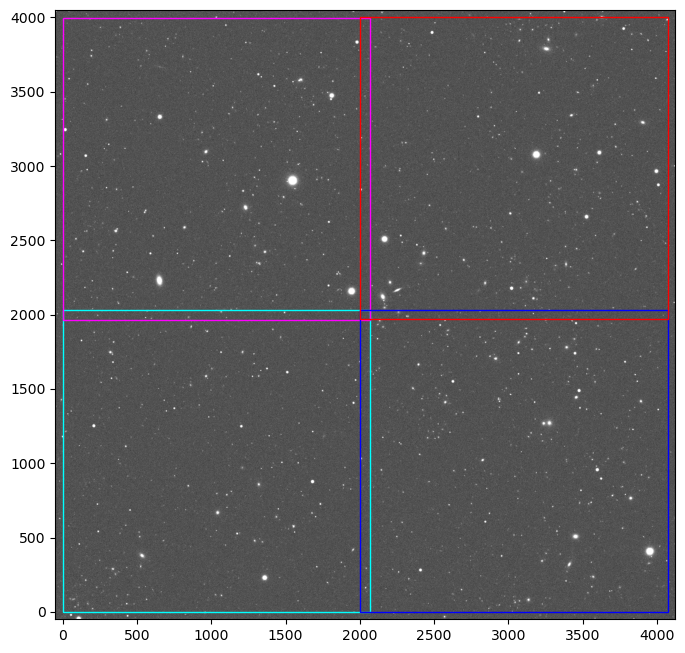

In [185]:
bbox = science.getBBox()
cropping_paras = cdia.CROPPING_PARAS
cropping_dim = 2
cparas = cropping_paras[cropping_dim]
Lx, Ly, width = cparas['Lx'], cparas['Ly'], cparas['width']
x_size, y_size = Lx*2, Ly*2

cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)
science_cutout_dict = cdia.crop_exposure(science, cropping_center, cropping_dim, x_size, y_size, save_dir=None)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cdia.plot_cutout_grid(ax, science, science_cutout_dict, cropping_dim, cropping_span, show_detection_grid=False)

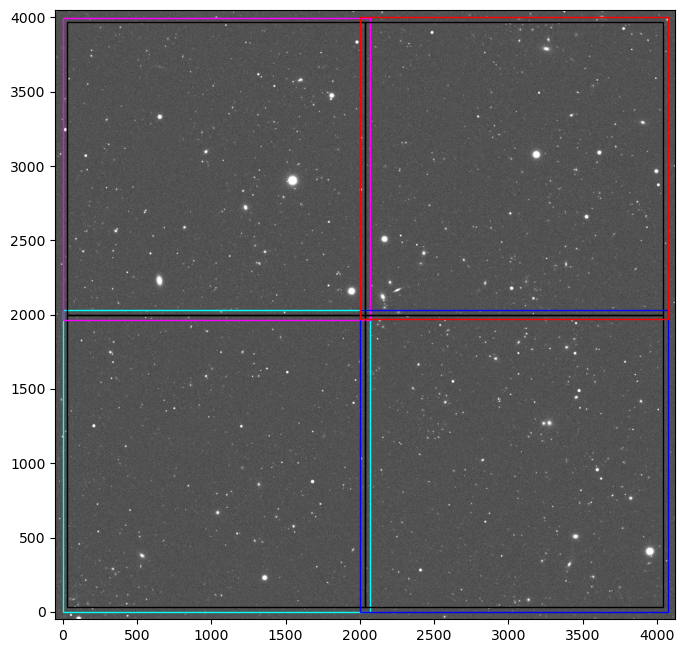

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cdia.plot_cutout_grid(ax, science, science_cutout_dict, cropping_dim, cropping_span)

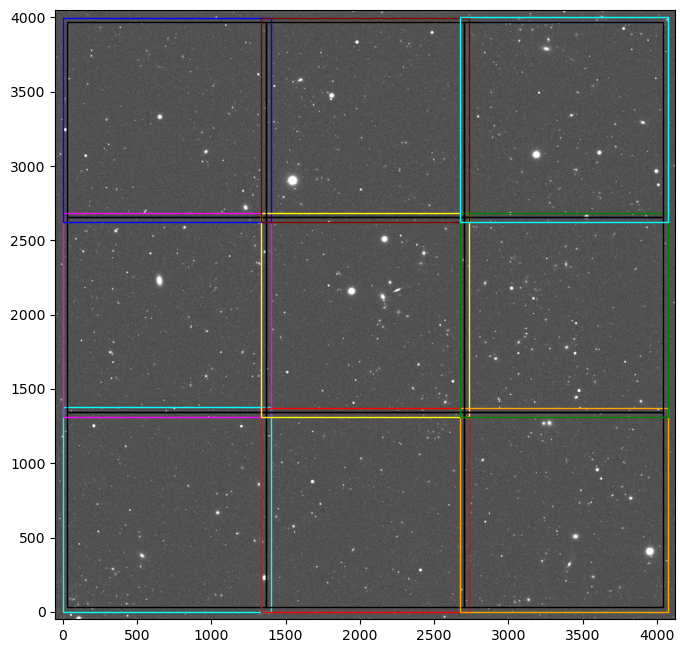

In [187]:
bbox = science.getBBox()
cropping_paras = cdia.CROPPING_PARAS
cropping_dim = 3
cparas = cropping_paras[cropping_dim]
Lx, Ly, width = cparas['Lx'], cparas['Ly'], cparas['width']
x_size, y_size = Lx*2, Ly*2

cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)
science_cutout_dict = cdia.crop_exposure(science, cropping_center, cropping_dim, x_size, y_size, save_dir=None)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cdia.plot_cutout_grid(ax, science, science_cutout_dict, cropping_dim, cropping_span)

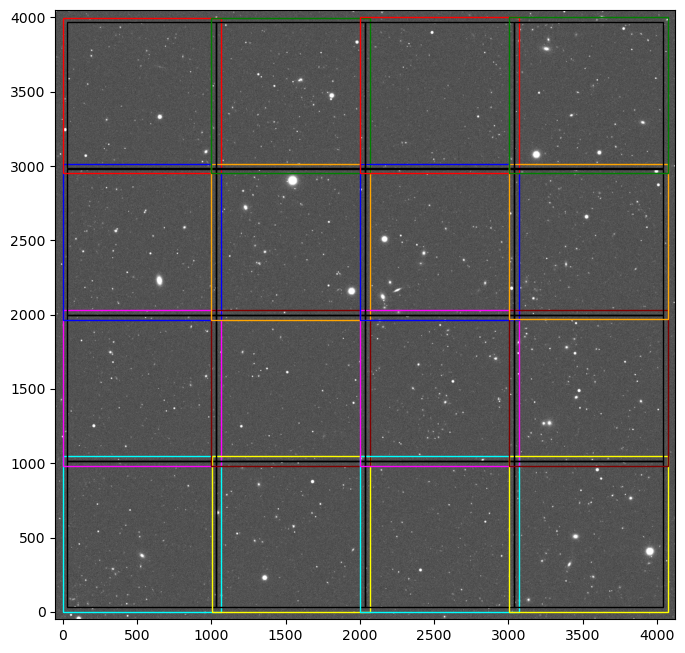

In [188]:
bbox = science.getBBox()
cropping_paras = cdia.CROPPING_PARAS
cropping_dim = 4
cparas = cropping_paras[cropping_dim]
Lx, Ly, width = cparas['Lx'], cparas['Ly'], cparas['width']
x_size, y_size = Lx*2, Ly*2

cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)
science_cutout_dict = cdia.crop_exposure(science, cropping_center, cropping_dim, x_size, y_size, save_dir=None)
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cdia.plot_cutout_grid(ax, science, science_cutout_dict, cropping_dim, cropping_span)

# Subtraction

In [189]:
bbox = science.getBBox()
cropping_paras = cdia.CROPPING_PARAS
cropping_dim = 4
cparas = cropping_paras[cropping_dim]
Lx, Ly, width = cparas['Lx'], cparas['Ly'], cparas['width']
x_size, y_size = Lx*2, Ly*2

cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)
science_cutout_dict = cdia.crop_exposure(science, cropping_center, cropping_dim, x_size, y_size, save_dir=None)

In [223]:
import pandas as pd 
offset = 10
data_dir = './test_cdia/diff_44'

concat_sources = pd.DataFrame()

for x in range(1, cropping_dim+1):
    for y in range(1, cropping_dim+1):

        center = cropping_center[f'{x}{y}']
        span = cropping_span[f'{x}{y}']
        cx, cy = center[0], center[1]
        
        science_cutout = science_cutout_dict[f'{x}{y}']
        bbox = science_cutout.getBBox()
        source_catalog_selected = cdia.select_source(source_catalog, bbox, offset)
        subtraction, detection = cdia.run_subtraction(science_cutout, template, source_catalog_selected, spatialKernelOrder=1, get_detection=True, verbose=True)
        
        diaSources = detection.diaSources.asAstropy().to_pandas()
        in_span_result = cdia.in_span(diaSources, span)
        diaSources['in_span'] = in_span_result
        diaSources['cutout_id'] = np.repeat(f'{x}{y}', len(diaSources))
        concat_sources = pd.concat([concat_sources, diaSources])
        detection.subtractedMeasuredExposure.writeFits(os.path.join(data_dir, f'diff_{x}{y}.fits'))
concat_sources = concat_sources.reset_index(drop=True)
concat_sources.to_csv(os.path.join(data_dir, 'concat_diaSources.csv'), index=False)

-------------------------------------------------------------------------------------------------
spatial order  1
convolution mode  convolveTemplate
201 stars are used for fitting: 
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
spatial order  1
convolution mode  convolveTemplate
183 stars are used for fitting: 
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
spatial order  1
convolution mode  convolveTemplate
150 stars are used for fitting: 
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
spatial order  1
convolution mode  convolveTemplate
146 sta

DipoleFitPlugin not run on record 0: edge failure


-------------------------------------------------------------------------------------------------
spatial order  1
convolution mode  convolveTemplate
177 stars are used for fitting: 
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
spatial order  1
convolution mode  convolveTemplate
203 stars are used for fitting: 
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
spatial order  1
convolution mode  convolveTemplate
188 stars are used for fitting: 
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
spatial order  1
convolution mode  convolveTemplate
208 sta

In [225]:
data_dir = './test_cdia/diff_uncropped'

subtraction, detection =  cdia.run_subtraction(science, template, source_catalog, spatialKernelOrder=1, get_detection=True, verbose=True)
diaSources = detection.diaSources.asAstropy().to_pandas()
detection.subtractedMeasuredExposure.writeFits(os.path.join(data_dir, f'diff.fits'))
diaSources.to_csv(os.path.join(data_dir, 'diaSources.csv'), index=False)

-------------------------------------------------------------------------------------------------
spatial order  1
convolution mode  convolveTemplate
2710 stars are used for fitting: 
-------------------------------------------------------------------------------------------------


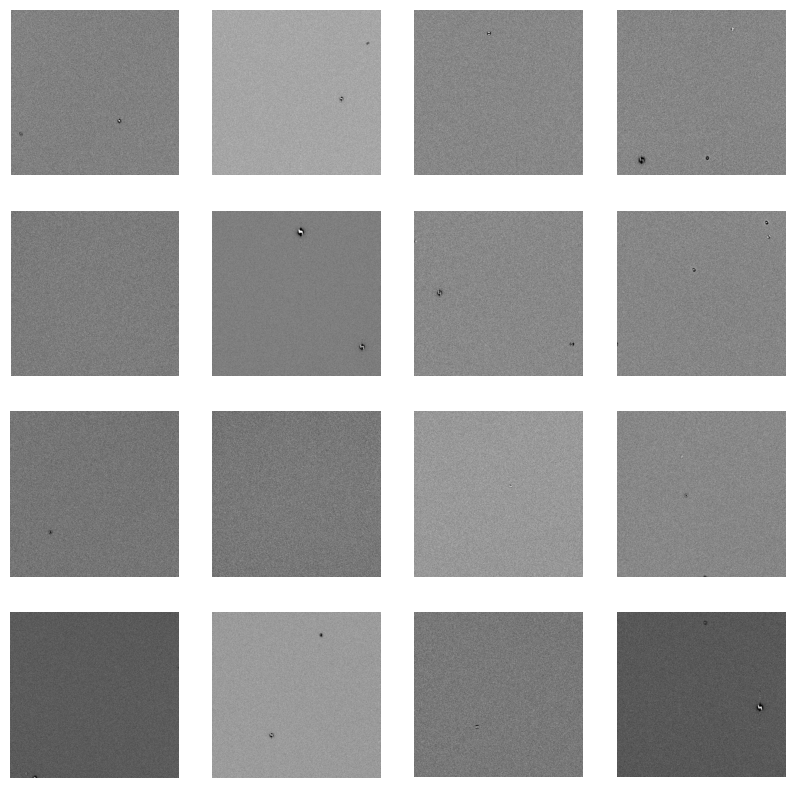

In [308]:
data_dir = './test_cdia/diff_44'

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for x in range(1, 5):
    for y in range(1, 5):
        cutout = afwImage.ExposureF(os.path.join(data_dir, f'diff_{x}{y}.fits'))
        axes[3-(y-1)][x-1].imshow(interval(cutout.getImage().array), cmap='gray', origin='lower')
        axes[3-(y-1)][x-1].set_axis_off()

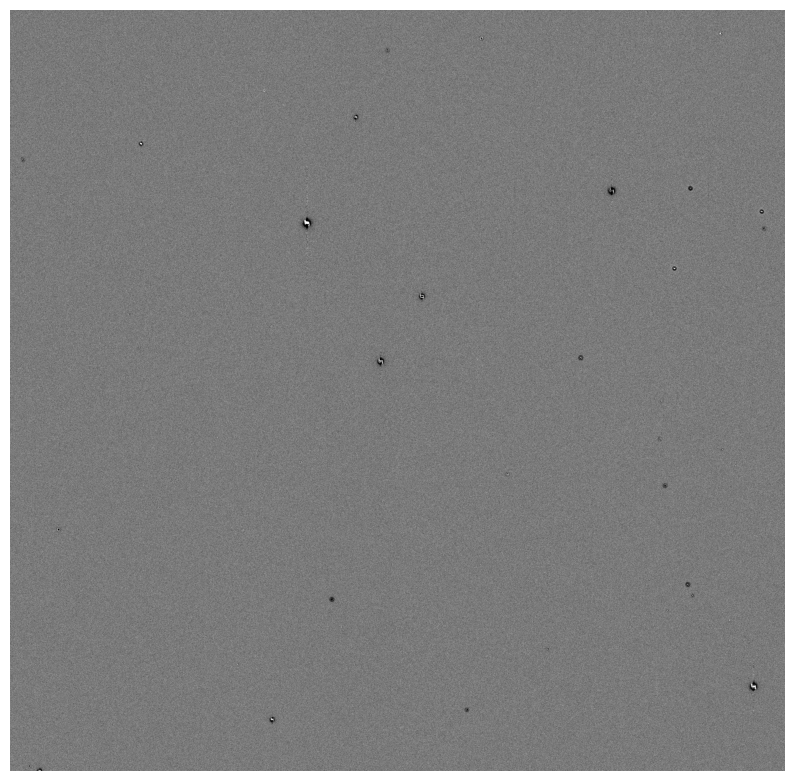

In [310]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(interval(detection.subtractedMeasuredExposure.getImage().array), cmap='gray', origin='lower')
ax.set_axis_off()

In [227]:
len(concat_sources), len(diaSources)

(39, 64)

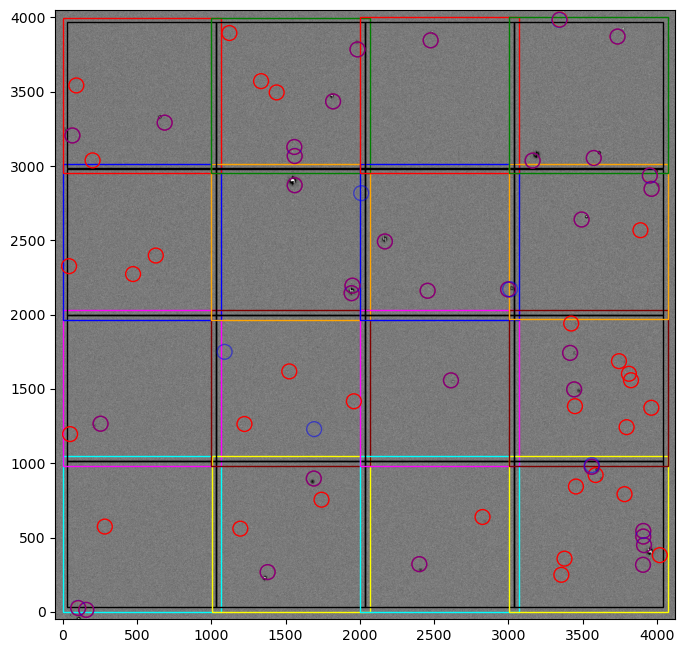

In [252]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
difference = detection.subtractedMeasuredExposure
bbox = difference.getBBox()
cdia.plot_cutout_grid(ax, difference, science_cutout_dict, cropping_dim, cropping_span)
cdia. add_circular_patch_from_source_table(ax, diaSources, bbox, color='r', alpha=1)
cdia. add_circular_patch_from_source_table(ax, concat_sources, bbox, color='blue', alpha=0.5)

In [255]:
concat_sources_selected = concat_sources.loc[concat_sources.in_span]

In [265]:
begin_x, begin_y = bbox.beginX + width, bbox.beginY + width
end_x, end_y = bbox.endX - 1 - width, bbox.endY - 1 - width
selected_id = cdia.in_box(diaSources.base_SdssCentroid_x, diaSources.base_SdssCentroid_y, begin_x, end_x, begin_y, end_y)
diaSources_selected = diaSources.loc[selected_id]

In [266]:
len(concat_sources_selected), len(diaSources_selected)

(33, 61)

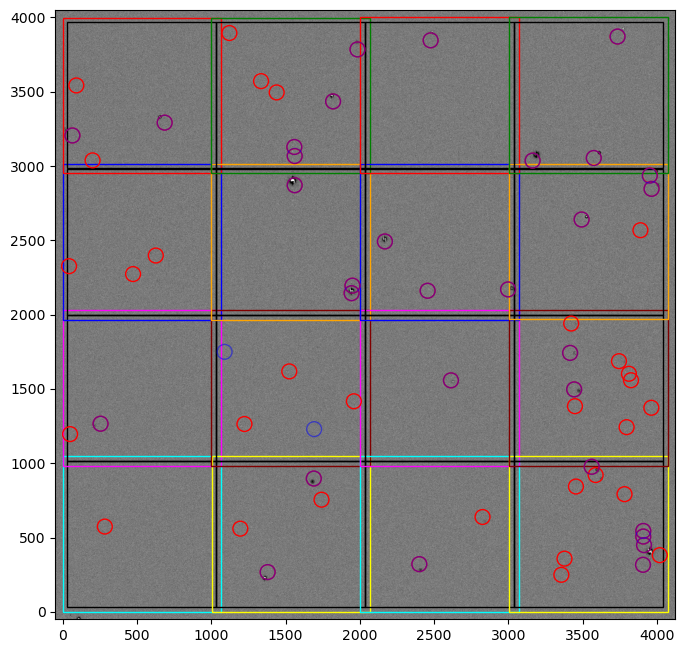

In [267]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
difference = detection.subtractedMeasuredExposure
bbox = difference.getBBox()
cdia.plot_cutout_grid(ax, difference, science_cutout_dict, cropping_dim, cropping_span)
cdia.add_circular_patch_from_source_table(ax, diaSources_selected, bbox, color='r', alpha=1)
cdia.add_circular_patch_from_source_table(ax, concat_sources_selected, bbox, color='blue', alpha=0.5)

In [277]:
data_dir = './test_cdia/diff_44'
cutout_22 = afwImage.ExposureF(os.path.join(data_dir, 'diff_22.fits'))
concat_sources_22 = concat_sources.loc[concat_sources.cutout_id == '22']
bbox_22 = cutout_22.getBBox()
len(concat_sources_22)

2

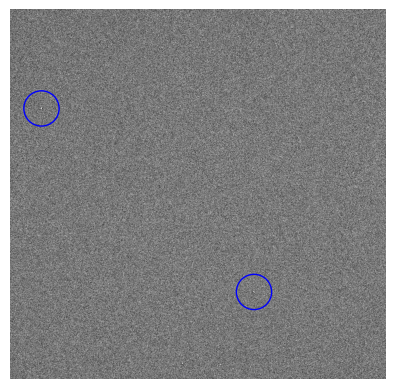

In [279]:
fig, ax = plt.subplots(1, 1)
ax.imshow(interval(cutout_22.getImage().array), origin='lower', cmap='gray')
ax.set_axis_off()
cdia.add_circular_patch_from_source_table(ax, concat_sources_22, bbox_22, color='b', alpha=1)

In [293]:
afwDisplay.setDefaultBackend('matplotlib')

def display_cutout(exposure, x, y, cutout_size=60):
    cutout = make_cutout(exposure, x, y, cutout_size=(cutout_size, cutout_size))
    print(cutout.getImage().array.sum())
    display = afwDisplay.Display(frame=None)
    # display.scale('linear', 'zscale')
    display.scale('asinh', 'zscale')
    # display.setMaskTransparency(100)
    display.mtv(cutout)

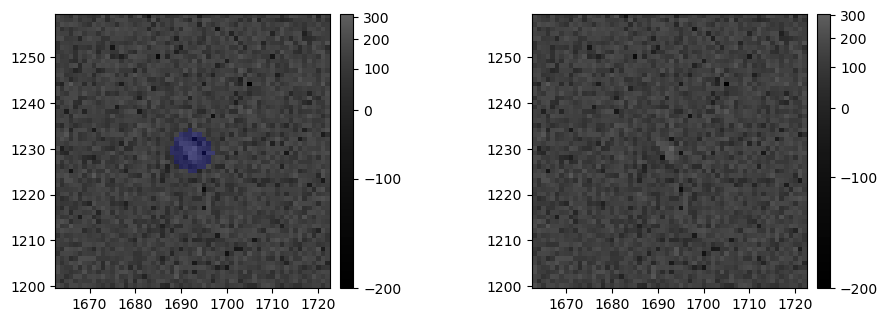

In [299]:
idx = 0
row = concat_sources_22.iloc[idx]
phys_x, phys_y= row['base_SdssCentroid_x'], row['base_SdssCentroid_y']

cutout_size = (60, 60)
figsize = (10, 8)
stamp1 = cdia.make_cutout(cutout_22, phys_x, phys_y, cutout_size)
stamp2 = cdia.make_cutout(difference, phys_x, phys_y, cutout_size)
stamps = [stamp1, stamp2]
fig, axes = plt.subplots(1, 2, figsize=figsize)
ax = axes.flat
fig.subplots_adjust(wspace=0.6)
for i in range(2):
    plt.sca(ax[i])
    display = afwDisplay.Display(frame=fig)
    # display.scale('linear', 'zscale')
    display.scale('asinh', 'zscale')
    display.setMaskTransparency(80)
    display.mtv(stamps[i])
    # print(stamps[i].getImage().array.sum())

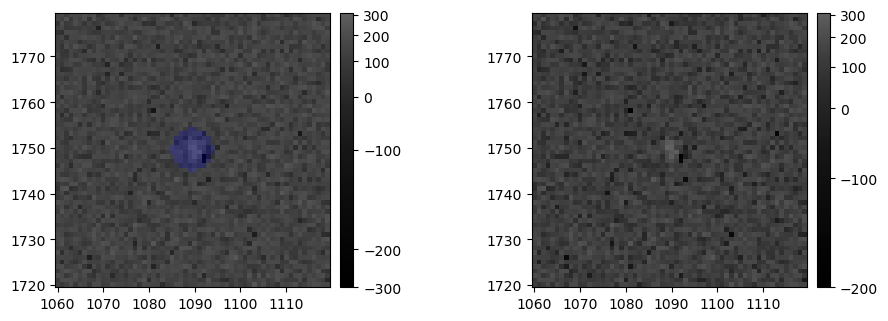

In [300]:
idx = 1
row = concat_sources_22.iloc[idx]
phys_x, phys_y= row['base_SdssCentroid_x'], row['base_SdssCentroid_y']

cutout_size = (60, 60)
figsize = (10, 8)
stamp1 = cdia.make_cutout(cutout_22, phys_x, phys_y, cutout_size)
stamp2 = cdia.make_cutout(difference, phys_x, phys_y, cutout_size)
stamps = [stamp1, stamp2]
fig, axes = plt.subplots(1, 2, figsize=figsize)
ax = axes.flat
fig.subplots_adjust(wspace=0.6)
for i in range(2):
    plt.sca(ax[i])
    display = afwDisplay.Display(frame=fig)
    # display.scale('linear', 'zscale')
    display.scale('asinh', 'zscale')
    display.setMaskTransparency(80)
    display.mtv(stamps[i])
    # print(stamps[i].getImage().array.sum())

# Synthetic Source Injection

In [166]:
bbox = science.getBBox()
cropping_paras = cdia.CROPPING_PARAS
cropping_dim = 4
cparas = cropping_paras[cropping_dim]
Lx, Ly, width = cparas['Lx'], cparas['Ly'], cparas['width']
x_size, y_size = Lx*2, Ly*2

cropping_center, cropping_span = cdia.get_cutout_center_and_span(bbox, cropping_dim=cropping_dim, Lx=Lx, Ly=Ly, width=width)
science_cutout_dict = cdia.crop_exposure(science, cropping_center, cropping_dim, x_size, y_size, save_dir=None)

In [268]:
"""
injected_mag = 20
for x in range(1, cropping_dim+1):
    for y in range(1, cropping_dim+1):
        science_cutout = science_cutout_dict[f'{x}{y}']
        x, y = cropping_center[f'{x}{y}']
        cdia.inject_star(science_cropped, photoCalib=science_cropped.getPhotoCalib(), x=x, y=y, mag=injected_mag)
""";      

In [ ]:
for coo in coords:
    x, y = coo
    inject_star(science_cropped, photoCalib=science_cropped.getPhotoCalib(), x=x, y=y, magVar=20)

# 

In [5]:
import numpy as np
from scipy.signal import fftconvolve
from collections import deque
from skimage.draw import disk
import matplotlib.pyplot as plt

from numpy.polynomial.polynomial import polyval2d
from numpy.polynomial.chebyshev import chebval2d
from scipy.stats import multivariate_normal

from sklearn import linear_model
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from patsy import dmatrix
from astropy.table import Table
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

import lsst.afw.image as afwImage
# import data_process_utils as dpu
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
from lsst.afw.table import BaseCatalog

# ipdiffim

from collections.abc import Sequence
import os
from typing import Union

import astropy.table
from astropy.wcs import WCS

import matplotlib.pyplot as plt


import lsst.afw.display as afwDisplay
import lsst.afw.image
from lsst.afw.math import Warper, WarperConfig
import lsst.afw.table
import lsst.geom as geom
import lsst.sphgeom

from lsst.pipe.tasks.makeWarp import MakeWarpConfig, MakeWarpTask
from lsst.ip.diffim import MakeKernelConfig, MakeKernelTask, PsfMatchConfig, PsfMatchConfigAL, PsfMatchConfigDF
from lsst.ip.diffim.subtractImages import _subtractImages
from lsst.ip.diffim.utils import evaluateMeanPsfFwhm, getPsfFwhm
from lsst.meas.algorithms import SourceDetectionTask, SubtractBackgroundTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.pex.exceptions import InvalidParameterError



In [9]:
"""
subtract_config = AlardLuptonSubtractConfig()
subtract_config.makeKernel.retarget(MakeKernelTask, ConfigClass=MakeKernelConfig)
task = AlardLuptonSubtractTask(config=subtract_config)
subtraction = subtract(science, template, source_catalog, task=task)
difference = subtraction.difference
detection_catalog = detect(science, subtraction)
dia_src = detection_catalog.diaSources.asAstropy()
""";

In [10]:
"""
template.writeFits('./test_dataset/template.fits')
science.writeFits('./test_dataset/science.fits')
difference.writeFits('./test_dataset/difference.fits')
source_catalog.writeFits('./test_dataset/source_catalog.fits')
detection_catalog.diaSources.writeFits('./test_dataset/diaSrc_catalog.fits')

template = afwImage.ExposureF('./test_dataset/template.fits')
science = afwImage.ExposureF('./test_dataset/science.fits')
difference = afwImage.ExposureF('./test_dataset/difference.fits')
source_catalog = BaseCatalog.readFits('./test_dataset/source_catalog.fits')
diaSrc_catalog = BaseCatalog.readFits('./test_dataset/diaSrc_catalog.fits')
diaSrc = diaSrc_catalog.asAstropy()
""";

In [17]:
def count_diaSrc_by_xy(table, min_x, max_x, min_y, max_y):
    count = 0
    for row in table:
        if min_x <= row['base_NaiveCentroid_x'] <= max_x and min_y <= row['base_NaiveCentroid_y'] <= max_y:
            count += 1
    return count


def compare_three_dets(det1, det2, det3):
    min_x = np.floor( min(det2['base_NaiveCentroid_x'].min(), det3['base_NaiveCentroid_x'].min()) )
    max_x = np.ceil( max(det2['base_NaiveCentroid_x'].max(), det3['base_NaiveCentroid_x'].max()) )
    min_y = np.floor( min(det2['base_NaiveCentroid_y'].min(), det3['base_NaiveCentroid_y'].min()) )
    max_y = np.ceil( max(det2['base_NaiveCentroid_y'].max(), det3['base_NaiveCentroid_y'].max()) )
    
    count1 = count_diaSrc_by_xy(det1, min_x, max_x, min_y, max_y)
    count2 = count_diaSrc_by_xy(det2, min_x, max_x, min_y, max_y)
    count3 = count_diaSrc_by_xy(det3, min_x, max_x, min_y, max_y)
    
    print('\n')
    print('count summary')
    print(f'original: {count1}, method1: {count2}, method2 {count3}')

In [18]:
def uncropped_vs_cropped(source_id, full_table, selected_table, science, template, difference, source_catalog, crop_size=1000, offset=10):
    # offset:    stars within offset pixels to the edge are not selected
    x, y = selected_table[source_id]['base_NaiveCentroid_x'], selected_table[source_id]['base_NaiveCentroid_y']
    science_cropped, diapipe_cropped, diff_cropped_1, diff_cropped_2 = show_cropped_stamps(
        science, template, difference, source_catalog, x, y, crop_size=crop_size, offset=offset)
    
    det_1 = detect(science_cropped,  diff_cropped_1)
    det_2 = detect(science_cropped, diff_cropped_2)
    
    # det_1 = detect(science,  diff_cropped_1)
    # det_2 = detect(science, diff_cropped_2)
    
    compare_three_dets(diaSrc, det_1.diaSources.asAstropy(), det_2.diaSources.asAstropy())    
    
    stamp1 = make_cutout(diapipe_cropped, x, y, cutout_size=100)
    stamp2 = make_cutout(det_1.subtractedMeasuredExposure, x, y, cutout_size=100)
    stamp3 = make_cutout(det_2.subtractedMeasuredExposure, x, y, cutout_size=100)
    compare_three_stamps(stamp1, stamp2, stamp3, figsize=(10,6))
    


In [19]:
def display_exposure_with_mask(exposure, frame=None):
    display = afwDisplay.Display(frame=frame)
    # display.scale('linear', 'zscale')
    display.scale('asinh', 'zscale')
    display.setMaskTransparency(80)
    display.mtv(exposure)
    
